In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Kidney
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Kidney data, Smart-seq2 assay in .h5ad format was used for further analysis.

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + 'TM_kidney.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx)

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 11241.02it/s]
1833it [00:02, 893.28it/s]


In [5]:
barcode.head()

,FACS.selection,age,cell,method,donor_id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.558838,6,2,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,m)Pp-;E&G5,-0.060743
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.010986,11,11,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,+OHz`3&s$%,-0.125682
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,male,kidney,na,18 month-old stage,*XqHa?vV$?,0.228744
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,kidney collecting duct epithelial cell,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,g$$6A-{$ul,0.316740
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760498,0,4,EFO:0008931,...,epithelial cell of proximal tubule,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,#*&4QwG9ZI,-0.161026


## CMA net score/cell type (fold over whole tissue)

In [6]:
# Checking n of mice 
print(list(barcode['mouse.id'].unique()))

['18_46_F', '18_47_F', '18_53_M', '18_45_M', '24_59_M', '24_58_M', '24_60_M', '24_61_M', '3_38_F', '3_39_F', '3_10_M', '3_11_M', '3_9_M', '3_8_M']


**Mice n for Liver**
    - Young females: 2
    - Young males: 4
    - Old females: 2
    - Old males: 6

In [6]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    else:                
        barcode.loc[j, 'new_age'] = '18-24m'

barcode.head()

,FACS.selection,age,cell,method,donor_id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.558838,6,2,EFO:0008931,...,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,m)Pp-;E&G5,-0.060743,18-24m
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.010986,11,11,EFO:0008931,...,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,+OHz`3&s$%,-0.125682,18-24m
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,Smart-seq2,normal,Mus musculus,male,kidney,na,18 month-old stage,*XqHa?vV$?,0.228744,18-24m
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,g$$6A-{$ul,0.316740,18-24m
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760498,0,4,EFO:0008931,...,Smart-seq2,normal,Mus musculus,female,kidney,na,18 month-old stage,#*&4QwG9ZI,-0.161026,18-24m


In [8]:
print(list(barcode.cell_type.unique()))

['epithelial cell of proximal tubule', 'kidney collecting duct epithelial cell', 'kidney loop of Henle ascending limb epithelial cell', 'macrophage', 'T cell', 'fenestrated cell', 'kidney collecting duct principal cell', 'B cell', 'mesangial cell', 'kidney interstitial fibroblast']


In [7]:
# Generating new cell types
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'epithelial cell of proximal tubule':        
        barcode.loc[j, 'new_cell'] = 'proximal tubule epithelial cell'
    
    elif barcode.loc[j, 'cell_type'] == 'kidney collecting duct epithelial cell' or barcode.loc[j, 'cell_type'] == 'kidney collecting duct principal cell':        
        barcode.loc[j, 'new_cell'] = 'collecting duct epithelial cell'

    else:                
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']
        

  0%|          | 0/1833 [00:00<?, ?it/s]

100%|██████████| 1833/1833 [00:00<00:00, 16020.50it/s]


In [8]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,method,donor_id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,new_cell,net_score
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.558838,6,2,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,m)Pp-;E&G5,-0.060743,18-24m,proximal tubule epithelial cell,-0.067226
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.010986,11,11,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,+OHz`3&s$%,-0.125682,18-24m,proximal tubule epithelial cell,-0.132165
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,Mus musculus,male,kidney,na,18 month-old stage,*XqHa?vV$?,0.228744,18-24m,proximal tubule epithelial cell,0.222261
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,g$$6A-{$ul,0.316740,18-24m,collecting duct epithelial cell,0.310257
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760498,0,4,EFO:0008931,...,Mus musculus,female,kidney,na,18 month-old stage,#*&4QwG9ZI,-0.161026,18-24m,proximal tubule epithelial cell,-0.167509


In [9]:
cells = ['mesangial cell', 'proximal tubule epithelial cell', 'collecting duct epithelial cell']

## CMA net score/cell type & sex (fold over each cell type, young)

In [10]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 9/9 [00:00<00:00, 76.20it/s]


,FACS.selection,age,cell,method,donor_id,n_genes,n_counts,louvain,leiden,assay_ontology_term_id,...,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,new_cell,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A12_B002350_B009947_S12.mm10-plus-4-0,Viable,18m,A12_B002350,facs,18_46_F,838,2339.558838,6,2,EFO:0008931,...,female,kidney,na,18 month-old stage,m)Pp-;E&G5,-0.060743,18-24m,proximal tubule epithelial cell,-0.067226,-0.115435
A12_B002352_B009948_S12.mm10-plus-4-0,Viable,18m,A12_B002352,facs,18_47_F,2306,4015.010986,11,11,EFO:0008931,...,female,kidney,na,18 month-old stage,+OHz`3&s$%,-0.125682,18-24m,proximal tubule epithelial cell,-0.132165,-0.180374
A13_B002697_B009938_S13.mm10-plus-4-0,Viable,18m,A13_B002697,facs,18_53_M,930,2256.614746,3,1,EFO:0008931,...,male,kidney,na,18 month-old stage,*XqHa?vV$?,0.228744,18-24m,proximal tubule epithelial cell,0.222261,0.174052
A15_B002352_B009948_S15.mm10-plus-4-0,Viable,18m,A15_B002352,facs,18_47_F,3547,5644.244141,11,11,EFO:0008931,...,female,kidney,na,18 month-old stage,g$$6A-{$ul,0.316740,18-24m,collecting duct epithelial cell,0.310257,0.311897
A16_B002352_B009948_S16.mm10-plus-4-0,Viable,18m,A16_B002352,facs,18_47_F,1658,3414.760498,0,4,EFO:0008931,...,female,kidney,na,18 month-old stage,#*&4QwG9ZI,-0.161026,18-24m,proximal tubule epithelial cell,-0.167509,-0.215718


### Graphs (fold over cell type)

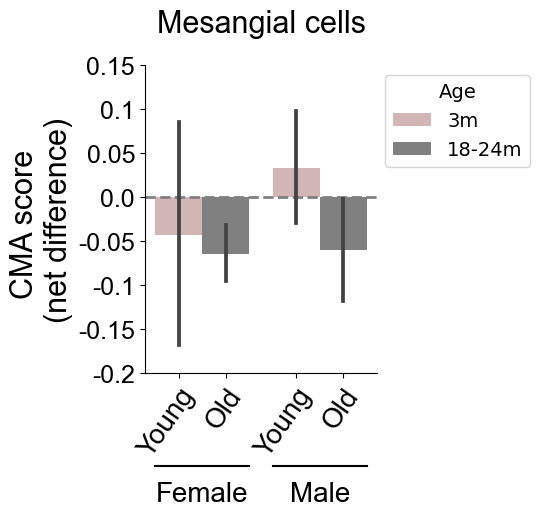

In [11]:
# Figure Mesangial cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='mesangial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.15)
ax.set_yticks([-.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15])
ax.set_yticklabels([-.20, -0.15, -0.10, -0.05, 0.00, 0.05, 0.10, 0.15], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Mesangial cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Mes_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

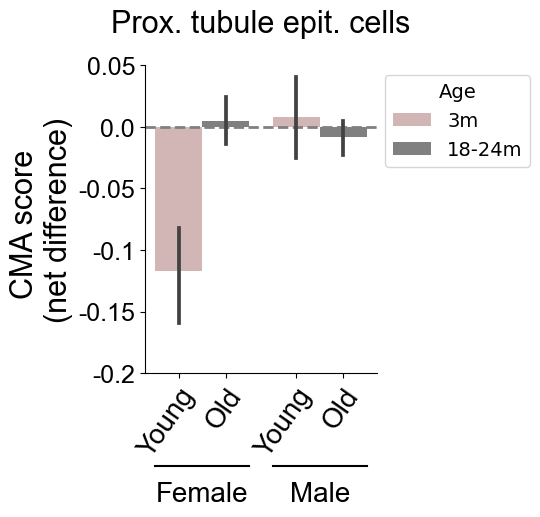

In [12]:
# Figure Prox. tub. epit. cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='proximal tubule epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.20, 0.05)
ax.set_yticks([-0.20, -0.15, -0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.20, -0.15, -0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Prox. tubule epit. cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Prox_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

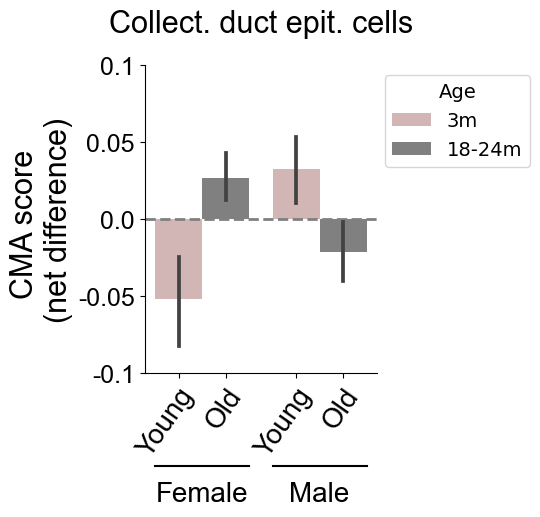

In [13]:
# Figure Collecting duct epit. cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='collecting duct epithelial cell'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.10)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Collect. duct epit. cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Col_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [14]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Kid_Raw_data.xlsx", sheet_name="CellNsbysex", index=False)

    return(df_raw)

In [15]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,mesangial cell,3m,female,14,-0.043206,0.140244
1,mesangial cell,3m,male,18,0.033605,0.063958
2,mesangial cell,18-24m,female,35,-0.064354,0.033363
3,mesangial cell,18-24m,male,26,-0.059515,0.063713
4,proximal tubule epithelial cell,3m,female,3,-0.117059,0.039179
5,proximal tubule epithelial cell,3m,male,43,0.008167,0.033456
6,proximal tubule epithelial cell,18-24m,female,85,0.004332,0.021252
7,proximal tubule epithelial cell,18-24m,male,262,-0.008673,0.014499
8,collecting duct epithelial cell,3m,female,69,-0.052013,0.028842
9,collecting duct epithelial cell,3m,male,110,0.032627,0.022525


## CMA network heatmaps by cell type & sex

In [16]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [17]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Kid_Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:3]+'_heat', index=True)
        
    #Plot heatmap including all conditions
    if cellpop == 'mesangial cell':
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}

        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(15.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
                
    else:
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(15), nogfap, fontsize=16, **hfont)

        plt.ylim(14.5, -0.5)

        plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        
        plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)            
            
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.5, 0.25), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.5, 4.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.25,-1.25],[4.75, 9.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.5, 9.75), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.25,-1.25],[10, 14.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    
    plt.savefig(output_dir + '/{}_heat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=300)
    
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 57.59it/s]


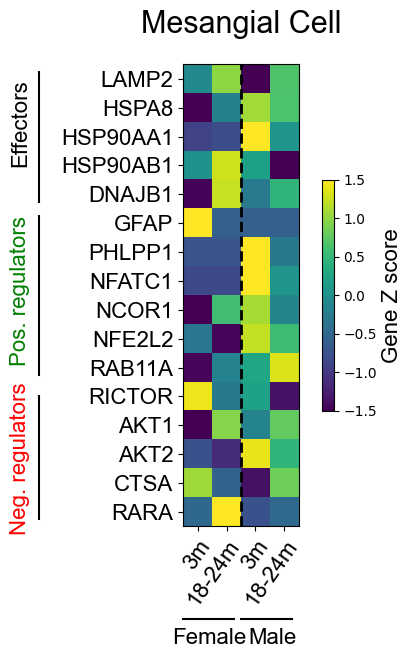

100%|██████████| 16/16 [00:00<00:00, 52.57it/s]


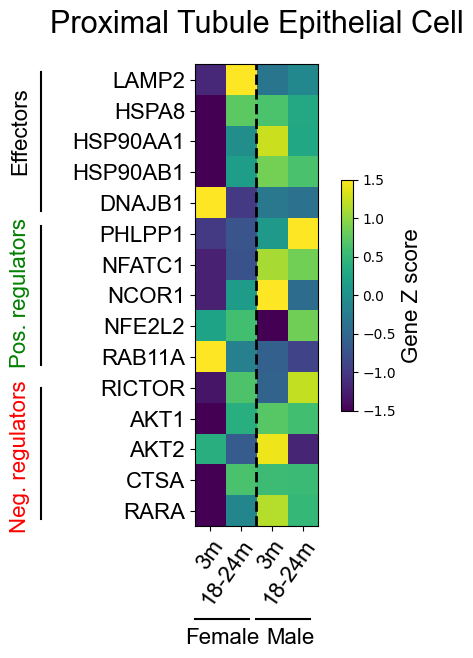

100%|██████████| 16/16 [00:00<00:00, 52.97it/s]


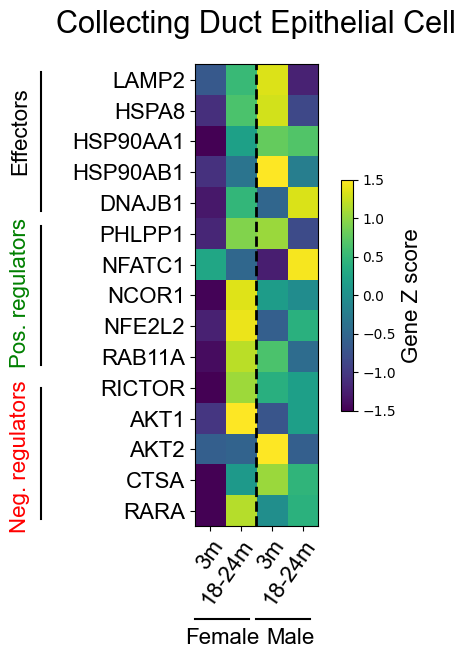

In [18]:
for i in cells:
    sex_heatmaps(cellpop=i)